# Model Fitting and Analysis

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import altair as alt

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)

alt.data_transformers.disable_max_rows()
alt.data_transformers.enable("data_server")

alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

### Data Import (Previous Script)

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-18/survey.csv"
)
#df = df[(df.annual_salary < 1000000) & (df.annual_salary > 10000)]
#df["state"] = df["state"].mask(df["state"].map(df["state"].value_counts()) < 5, "")
#df["city"] = df["city"].mask(df["city"].map(df["city"].value_counts()) < 5, "")
#df.fillna({"industry":"", "job_title":""}, inplace=True)
df.head()

,timestamp,how_old_are_you,industry,job_title,additional_context_on_job_title,annual_salary,other_monetary_comp,currency,currency_other,additional_context_on_income,country,state,city,overall_years_of_professional_experience,years_of_experience_in_field,highest_level_of_education_completed,gender,race
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,55000,0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,54600,4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,34000,NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,NaN,62000,3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,60000,7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


In [3]:
df_dropcurrency = df[df["currency"] == "USD"].drop(
    columns=["currency", "currency_other"]
)
df_dropcountry = df_dropcurrency[
    df_dropcurrency["country"]
    .str.lower()
    .isin(
        [
            "us",
            "usa",
            "u.s.",
            "u.s.a",
            "united states",
            "america",
            "united states of america",
        ]
    )
].drop(columns=["country", "gender", "race", "timestamp"])

# split the data before EDA
train_df, test_df = train_test_split(df_dropcountry, test_size=0.3, random_state=123)

### Data Processing (Script 1)

In [4]:
train_df = train_df[(train_df["annual_salary"] < 1000000) & (train_df["annual_salary"] > 10000)]
train_df["state"] = train_df["state"].mask(train_df["state"].map(train_df["state"].value_counts()) < 5, "")
train_df["city"] = train_df["city"].mask(train_df["city"].map(train_df["city"].value_counts()) < 5, "")

train_df.fillna({"industry":"", "job_title":""}, inplace=True)
test_df.fillna({"industry":"", "job_title":""}, inplace=True)

X_train, y_train = train_df.drop(columns=["annual_salary"]), train_df["annual_salary"]
X_test, y_test = test_df.drop(columns=["annual_salary"]), test_df["annual_salary"]

In [5]:
y_test

8088      61200
19060     68000
2033      38000
9659      94500
9765      90000
          ...  
25289    126000
12257     98000
23460     58000
14496    101759
9865      94000
Name: annual_salary, Length: 6445, dtype: int64

In [6]:
categorical_features = ["state", "city"]
text_feature1 = "industry"
text_feature2 = "job_title"
numeric_features = ["other_monetary_comp"]
drop_features = ["additional_context_on_job_title", "additional_context_on_income"]
ordinal_features = ["how_old_are_you", "overall_years_of_professional_experience",
                    "years_of_experience_in_field", "highest_level_of_education_completed"]
passthrough_features = []


In [7]:
#create list of lists for ordinal encoding

age_order = ["missing_value", "under 18", "18-24", "25-34", "35-44", "45-54", "55-64", "65 or over"]
exp_order = ["missing_value", "1 year or less", "2 - 4 years", "5-7 years", "8 - 10 years",
             "11 - 20 years", "21 - 30 years", "31 - 40 years", "41 years or more"]
edu_order = ["missing_value", "High School", "Some college", "College degree",
             "Master's degree", "Professional degree (MD, JD, etc.)",
             "PhD"]

In [8]:
preprocessor = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy="constant"),
            OneHotEncoder(handle_unknown="ignore", sparse=False, dtype ="int")
        ),
        categorical_features
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="constant", fill_value=0),
            StandardScaler()
        ),
        numeric_features
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="constant"),
            OrdinalEncoder(categories=[age_order, exp_order, exp_order, edu_order], dtype=int),
            StandardScaler()
        ),
        ordinal_features
    ),
    (
        CountVectorizer(max_features=5000, stop_words="english"),
        text_feature1
    ),
    (
        CountVectorizer(max_features=5000, stop_words="english"),
        text_feature2
    )
)

In [25]:
X_transformed_train = preprocessor.fit_transform(X_train)
X_transformed_test = preprocessor.transform(X_test)

feats =\
    list(preprocessor.transformers_[0][1][1].get_feature_names_out(categorical_features)) +\
    numeric_features + ordinal_features +\
    list(preprocessor.transformers_[3][1].get_feature_names_out()) +\
    list(preprocessor.transformers_[4][1].get_feature_names_out())

X_transformed_wcoef = pd.DataFrame(X_transformed_train.todense(), columns = feats)
X_transformed_wcoef_test = pd.DataFrame(X_transformed_test.todense(), columns = feats)

In [10]:
#X_transformed_train = preprocessor.fit_transform(X_train).toarray()
#X_test_transformed = preprocessor.transform(X_test).toarray()

### Fitting the Ridge Model (SCRIPT 2)

In [11]:
#X_transformed_train = np.loadtxt("../data/processed/X_train.csv", delimiter=",")
#X_transformed_test = np.loadtxt("../data/processed/X_test.csv", delimiter=",")


In [12]:
#y_train = pd.read_csv("../data/processed/y_train.csv")
#y_test = pd.read_csv("../data/processed/y_test.csv")

In [13]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

score_types_reg = {
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "mape_scorer": mape_scorer,
}

In [14]:
#cv_scores = cross_validate(Ridge(), X_transformed_train, y_train, return_train_score=True, scoring="r2")
#pd.DataFrame(cv_scores)

In [15]:
param_grid_cgamma = {"alpha": np.logspace(-5, 5, 20)}

random_search = RandomizedSearchCV(
    Ridge(),
    param_distributions=param_grid_cgamma,
    verbose=1,
    n_jobs=-1,
    n_iter=20,
    cv=5,
    random_state=123,
    scoring=score_types_reg,
    refit=False)

random_search.fit(X_transformed_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])},
                   random_state=123, refit=False,
                   scoring={'mape_scorer': make_scorer(mape, greater_is_better=False),
                            'neg_mean_absolute_error': 'neg_mean_absolute_error',
                            'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                            'r2': 'r2'},
                   verbose=1)

In [16]:
gridsearch_results = pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_r2",
        "mean_test_neg_root_mean_squared_error",
        "param_alpha",
        "rank_test_r2"
    ]
].set_index("rank_test_r2").sort_index()

gridsearch_results.columns = ["r2", "Negative RMSE", "alpha"]
gridsearch_results.index.names = ["r2 score rank"]
gridsearch_results["alpha"][1]
gridsearch_results

,r2,Negative RMSE,alpha
r2 score rank,,,
1,0.492954,-37937.928995,6.158482
2,0.488452,-38105.922629,20.691381
3,0.487138,-38155.446713,1.832981
4,0.474127,-38636.969106,0.545559
5,0.470900,-38754.306866,69.51928
6,0.459632,-39165.674583,0.162378
7,0.448956,-39550.084764,0.048329
8,0.443328,-39751.138456,0.014384
9,0.441062,-39831.771808,0.004281


In [35]:
import sklearn.metrics as sk
import math

ideal_model = Ridge(alpha=6.158482)
ideal_model.fit(X_transformed_train, y_train)
y_pred = ideal_model.predict(X_transformed_test)

y_pred
y_test

8088      61200
19060     68000
2033      38000
9659      94500
9765      90000
          ...  
25289    126000
12257     98000
23460     58000
14496    101759
9865      94000
Name: annual_salary, Length: 6445, dtype: int64

In [42]:
pd.DataFrame(data=ideal_model.coef_, index=feats, columns=["coefficient"]).sort_values("coefficient")[:10]
asd = pd.DataFrame(data=ideal_model.coef_, index=feats, columns=["coefficient"]).sort_values("coefficient", ascending = False)[:10].reset_index()
asd.columns = ["Feature", "Coefficient"]
asd

,Feature,Coefficient
0,physician,75981.970434
1,svp,63573.710217
2,md,62364.448297
3,partner,59051.402540
4,psychiatrist,53833.907168
5,city_Bay Area,47098.705022
6,equity,45696.287655
7,chief,44228.771696
8,machine,42013.912025
9,onlyfans,41326.622659


In [27]:
r2 = round(sk.r2_score(y_test, y_pred),2)
rmse = round(math.sqrt(sk.mean_squared_error(y_test, y_pred)),2)

scores = {
    "Metric": ["R2", "RMSE"],
    "Scores": [r2, rmse]
}
pd.DataFrame(scores)

,Metric,Scores
0,R2,0.38
1,RMSE,48429.23


In [28]:
y_data = {
    "y_pred": y_pred,
    "y_actual": y_test
}


#salary_data["annual_salary_pred"] = pd.Series(y_pred.flatten())
#salary_data.columns = ["y_actual", "y_pred"]
salary_data = pd.DataFrame(y_data)
salary_data

,y_pred,y_actual
8088,81353.043467,61200
19060,86252.901229,68000
2033,57691.972612,38000
9659,118995.514062,94500
9765,73976.298511,90000
...,...,...
25289,81338.323711,126000
12257,109875.055811,98000
23460,73105.008417,58000
14496,119915.567075,101759


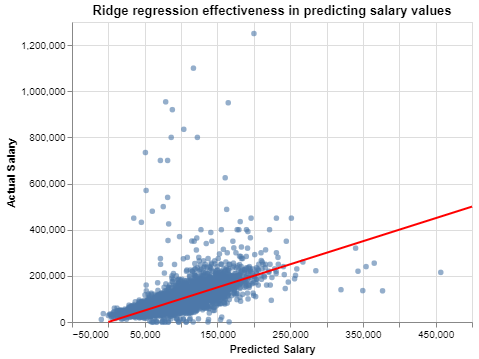

In [29]:
from altair_saver import save

point = alt.Chart(salary_data, title='Ridge regression effectiveness in predicting salary values').mark_circle(opacity = 0.6).encode(
    alt.X("y_pred", title="Predicted Salary"),
    alt.Y('y_actual', title="Actual Salary")
)

line = pd.DataFrame({
    'x': [0, 500000],
    'y':  [0, 500000],
})

line_plot = alt.Chart(line).mark_line(color= 'red').encode(
    x= 'x',
    y= 'y',
)

chart = point + line_plot
chart